<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/notebooks/tutorials/advanced_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3
## Question 3 - Micro Canonical Hamilitonian Monte Carlo

Over the course of this class, we have talked about Monte Carlo sampling quite a few times. In this question, we will utilise a new method of sampling to sample data, applying the MCMC approach to model the volatility of the S&P500 index.

The MCHMC Sampling Approach relies on Hamiltonian Dynamics to complete sampling.

Consider a sampling problem. Suppose that we have a density $p(\theta\mid y)$ to sample from to draw parameters $\theta$ for data y. The Hamiltonian sampling approach draws auxillary momentum by solving the Hamilton's equations. The idea of Hamiltonian Monte Carlo algorithms were discussed in Lecture 6, and the basics of the idea is to add a momentum to the basic Metropolis Hastings MCMC, and to solve for the next step using the Hamilton's equations from physics.


In this problem, we will use a Micro-Canonical Hamiltonian Monte Carlo sampler (as described in [this](https://arxiv.org/pdf/2212.08549.pdf) paper) to model the stochastic volatility of the returns on the S&P500 index. The sampling code is provided for you, but you will be expected to implement the mathematical log posteriors and model, with the goal of familiarizing you briefly with [Jax](https://jax.readthedocs.io/en/latest/), a package for high performance compting with auto differentiation.


We have $N = 2427$ values of the returns on the S\&P500 index $\{ r_n\}_{n = 1}^{N}$ in the time span of 10 years. Let's download the data and visualize it.

In [ ]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 19})

from numpyro.examples.datasets import SP500, load_dataset
from numpyro.distributions import StudentT


We have $N = 2427$ values of the returns on the S\&P500 index $\{ r_n\}_{n = 1}^{N}$ in the time span of 10 years. Let's download the data and visualize it.

In [ ]:
# Load the data
_, fetch = load_dataset(SP500, shuffle=False)
SP500_dates, SP500_returns = fetch()

1. **Plot and visualize the data below. Make sure to label the x axis with dates.**

*hint: to convert the string dates in SP500_dates into values for matplotlib, first use mdates.datestr2num to convert the strings into integer dates then use mdates.num2date to convert the integer dates into date time objects*

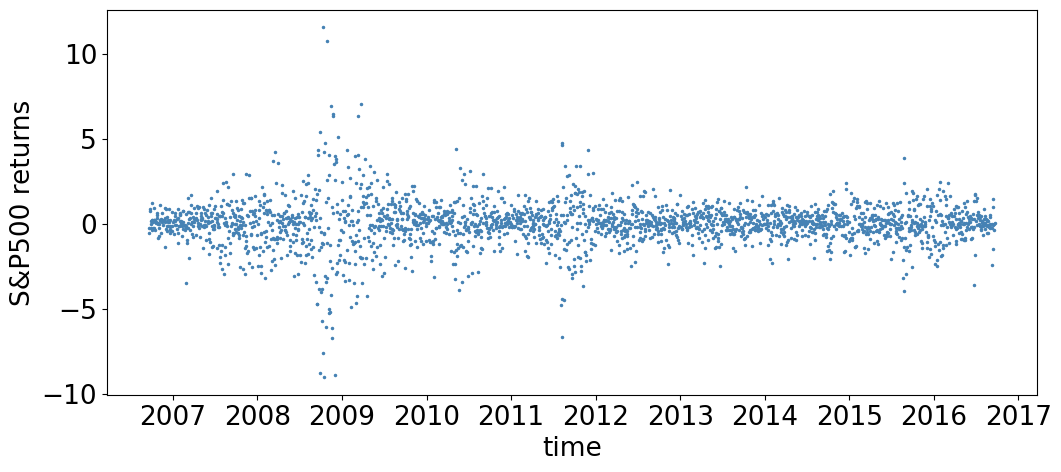

In [ ]:
# figure setup
plt.figure(figsize = (12, 5))

SP500_dates_mpl = mdates.num2date(mdates.datestr2num(SP500_dates))
# plot data
plt.plot(SP500_dates_mpl, SP500_returns, '.', markersize = 3, color= 'steelblue')

plt.xlabel('time')
plt.ylabel('S&P500 returns')
plt.show()

As you can see, the volatility seems to change over time significantly, but clusters around certain time periods. For example, we can easily see the 2008 financial crisis from the data above.

Generally speaking, asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, [Hoffman (2011)](https://arxiv.org/pdf/1111.4246.pdf) p21:

We model this volatility as follows:
\begin{equation}
\begin{split}
    \sigma &\sim \text{Exp}(\lambda = 50) \\
    \nu &\sim \text{Exp}(\lambda = 0.1) \\
    \log R_n &\sim \mathcal{N}(\log R_{n-1}, \sigma) \\
    r_n &\sim \text{Student's-t}(\nu, 0, R_n)
\end{split}
\end{equation}

where $r_n$ are the daily returns (the data) and the scale volatility $R_n$ is time-varying and unknown. The prior for $\log R_n$ is a Gaussian random walk with an exponential distribution of the random walk step-size $\sigma$. An exponential prior is also taken for the Student's-t degrees of freedom $\nu$

Note that the parameters in the Student's t distribution are the degrees of freedom, the location parameter (centre of the distribution) and the scale parameter (width). See [here](https://distribution-explorer.github.io/continuous/student_t.html) for a refresher on the Student's t distribution.


Our task in this problem then is to find the posterior of the parameters $\{R_n\}_{n=1}^N, \sigma$ and $\nu$, given the observed data $\{r_n\}_{n =1}^N$.

We have to make the configuration space unconstrained ($\boldsymbol{x} \in \mathbb{R}^d$). In the original form, the parameters were all positive, so we take the logarithms of our parameters:
\begin{equation}
  \boldsymbol{x} = ( \log R_1,\, \log R_2, \,... \log R_N, \,\log \lambda_{\sigma} \sigma,\, \log \lambda_{\nu} \nu).
\end{equation}

Let's implement an instance of the target density class. `nlogp` $= -\log p(\boldsymbol{x})$ has to be implemented by hand, but the gradient can be computed by jax.
We also define the transform function which maps to the constrained space (essentially taking the exponent of the variables).


### Our Sampling class `StochasticVolatility` needs a few methods for the sampler to work: `nlogp`, `transform`, and `prior_draw`

## `nlogp`
The `nlogp` method is the negative log-likelihood:
\begin{align}
    -\log p(x) &= - \log \left[P(\boldsymbol{r} | \log(\boldsymbol{R}), \nu, \sigma) P(\log(\boldsymbol{R})) P(\nu, \sigma)  \right]\\
    &=- \log \left[\left(\prod_{n=1}^N P(r_n | \log R_n, \nu, \sigma)P(\log R_n)\right) P(\nu, \sigma) \right] \\
    &= - \left(\sum_{n=1}^N\log P(r_n | R_n, \nu, \sigma)\right) - \left(\sum_{n=1}^N \log P(\log R_n) \right) - \log P(\nu, \sigma)
\end{align}

Where $P(\nu, \sigma)$ and $P(R_n)$ are the priors on $\nu, \sigma$ and $R_n$ respectively. Given an input parameter `x` (described above as the log of all $R_n$ parameters as well as $\lambda_\sigma \sigma$ and $\lambda_\nu \nu$), we want this function to compute the log likelihood of any given sample subject to the priors on parameters as described above.

*   The log likelihood function itself $\log P(r_n | R_n, \nu, \sigma)$ is the Student's T distribution as described above. To obtain the log-likelihood for any particular $R_n$, we use the `StudentT` class as previously imported. The log-likelihood for $r_n$ is given by:
        StudentT(df=nu, scale=R[i]).log_prob(r[i])
where `R[i] = jnp.exp(x[i])` and `r[i]` is the $i$-th point in `SP500_returns`.
Also note that `x` has length $N+2$ for the last parameters $\nu$ and $\sigma$ so make sure to not include the last two elements.
*   The log priors $\log P(\nu, \sigma)$ are simply the log of the PDF of the exponential function given the relevant $\lambda$ values. Recall that the PDF of the Exponential distribution is given by (for $x \geq 0$):
$$P(x | \lambda) = \lambda e^{-\lambda x}$$
So the log prior is given by
\begin{align}
\log P(\nu, \sigma) &= \log\left(P(\nu | \lambda_\nu) P(\sigma | \lambda_\sigma)\right) \\
&= \log ( \lambda_\nu e^{-\lambda_\nu \nu}) + \log(\lambda_\sigma e^{-\lambda_\sigma \sigma}) \\
&= -\lambda_\nu \nu + \log(\lambda_\nu) -\lambda_\sigma \sigma + \log(\lambda_\sigma)
\end{align}
*   The log prior $\log P(\log R_n) $ is the final component. ***(NOTE: $\log R_n$ is actually the parameter we are getting the prior for, not $R_n$ itself. This is because $\log R_n$ is the parameter being drawn from the normal distribution, and $R_n$ is simply a function of $\log R_n$. You may find it clearer in your head if you define $s_n = \log R_n$ and $R_n = \exp s_n$, but it's the same thing in either case.)***  

  Here, we note that as each $\log R_n$ is being drawn from a normal distribution, the PDF is given by
  $$P(\log R_n) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left( -\frac12 \frac{(\log R_n - \log R_{n-1})^2}{\sigma^2}\right)$$
  with
  $$P(\log R_1) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left( -\frac12 \frac{(\log R_1)^2}{\sigma^2}\right)$$
  and the total log prior is given by
  \begin{align}
  \sum_{n=1}^N  \log P(\log R_n) &= -N\log(\sigma) - \frac{N}{2}\log(2\pi) - \frac{1}{2} \left(\sum_{n=2}{N} \frac{(\log R_n - \log R_{n-1})^2}{\sigma^2}
  + \frac{(\log R_1)^2}{\sigma^2}\right)
  \end{align}



## `transform`
Recall that the vector $\boldsymbol{x}$ we use for sampling is the logarithm of the parameters $\{R_n\}_{n=1}^{N}$ , $\lambda_\sigma \sigma$ and $\lambda_\nu \nu$, but the vector of parameters we actually want is
$$\boldsymbol{v} = (R_1, R_2, \dots , R_N, \sigma, \nu)$$
The `transform` method simply transforms from the $\boldsymbol{x}$ vector to the desired vector $\boldsymbol{v}$.

## `prior_draw`
To sample from the priors described before, we need a method that is capable of drawing samples from priors. Recall from above that $\log R_n$ is sampled from a Gaussian random walk, while $\sigma$ and $\nu$ are sampled from Exponential distributions with $\lambda_\sigma$ and $\lambda_\nu$ respectively.

The code for the Gaussian random walk sampling is already given to you, but fill out the lines for sampling $\sigma$ and $\nu$ using the function `jax.random.exponential` with the associated random keys `key_exp1` and `key_exp2`.

*Hint: If the random variable $X$ is a standard exponential with PDF $e^{-x}$, then for a positive $\lambda$, the random variable $Y = \frac{X}{\lambda}$ has the PDF $\lambda e^{-\lambda x}$.*

## **Questions:**

2.   **Implement the `nlogp` method using the mathematical formalism described above.**
3.   **Implement the `transform` method as described above.**
4.   **Implement the `prior_draw` method as described above.**



In [ ]:
import jax
import jax.numpy as jnp
jax.config.update("jax_debug_nans", True)


class StochasticVolatility():

    def __init__(self):

        self.d = 2429

        self.lambda_sigma = 50
        self.lambda_nu = 0.1

        self.grad_nlogp = jax.value_and_grad(self.nlogp) # we compute the gradient using jax


    def nlogp(self, x):
        """negative log p of the target distribution"""

        sigma = jnp.divide(jnp.exp(x[-2]), self.lambda_sigma) # get sigma from x
        nu = jnp.divide(jnp.exp(x[-1]), self.lambda_nu) # get nu from x

        r = jnp.array(SP500_returns)
        N = self.d - 2
        # R = jnp.exp(x[:-2])

        prior2 = (-self.lambda_nu * nu + jnp.log(self.lambda_nu)
                  - self.lambda_sigma * sigma + jnp.log(self.lambda_sigma)) # log prior(sigma, nu)
        prior1 =  (- N*jnp.log(sigma) - 0.5*N*jnp.log(2*jnp.pi)  -
                   0.5/jnp.square(sigma) * jnp.sum(jnp.square(x[:-2] - jnp.append(jnp.asarray(0), x[:-3])))) # log prior(R), don't think last term should be multiplied by N (like in problem statement)
        lik = jnp.sum(StudentT(df=nu, scale=jnp.exp(x[:-2])).log_prob(r)) #  log likelihood
        return -(lik + prior1 + prior2)


    def transform(self, x):
        """transform x back to the parameters R, sigma and nu (taking the exponent)"""
        v = jnp.exp(x)
        v = v.at[-2].divide(self.lambda_sigma)
        v = v.at[-1].divide(self.lambda_nu)

        return v


    def prior_draw(self, key):
        """draws x from the prior"""

        key_walk, key_exp1, key_exp2 = jax.random.split(key, 3) # Splitting one pseudo-random key into three for each sampler draw.

        sigma = jax.random.exponential(key_exp1) / self.lambda_sigma # sigma is drawn from the exponential distribution
        nu = jax.random.exponential(key_exp2) / self.lambda_nu

        def step(track, useless): #one step of the gaussian random walk
            randkey, subkey = jax.random.split(track[1])
            x = jax.random.normal(subkey, shape= track[0].shape, dtype = track[0].dtype) + track[0]
            return (x, randkey), x

        log_Rn = jax.lax.scan(step, init=(0.0, key_walk), xs=None, length=self.d - 2)[1] * sigma # = log R_n are drawn as a Gaussian random walk realization, has shape d-2

        x = jnp.append(log_Rn, jnp.array([jnp.log(self.lambda_sigma * sigma), jnp.log(self.lambda_nu * nu)])) # remember x has shape d

        return x



Now we can sample from the defined target using MCHMC.

In [ ]:
!pip install mclmc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 37.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
 

We take 5000 samples and use the built-in automatic hyperparameter tuning of the MCHMC package.

In [ ]:
from mclmc.sampler import Sampler

sampler = Sampler(StochasticVolatility())

In [ ]:
samples = sampler.sample(5000)

In [ ]:
samples.shape

(5000, 2429)


We want to visualize the posterior. First, we compute the median $R_n$ and its quartiles:

<span style="color:blue"> 5.
We want to visualize the posterior. First, we compute the median $R_n$ and its quartiles. `samples` produces an array of shape (5000, 2429), each row has been transformed using your transform function above into
$$\boldsymbol{v} = \{R_1, R_2, \dots, R_n, \sigma, \nu\}$$
Using `samples`, compute the median $R_n$ values and the first and third quartiles. Remember to remove the last two columns as those are representative of $\sigma$ and $\nu$. </span> <br>

In [ ]:
lower_quartile, median, upper_quartile = np.percentile(samples[:,:-2], 25, axis=0), np.median(samples[:,:-2], axis=0), np.percentile(samples[:,:-2], 75, axis=0)

Now, we can visualize the time dependant volatility:

<span style="color:blue"> 6. Now, we can visualize the time-dependent volatility. Plot the median of the scale volatility $R_n$ on top of the returns data from part 1. Also use `plt.fill_between` to plot the region between the first and third quartiles of $R_n$. Make sure to label the $x$ axis with years and to include a legend.
 </span> <br>

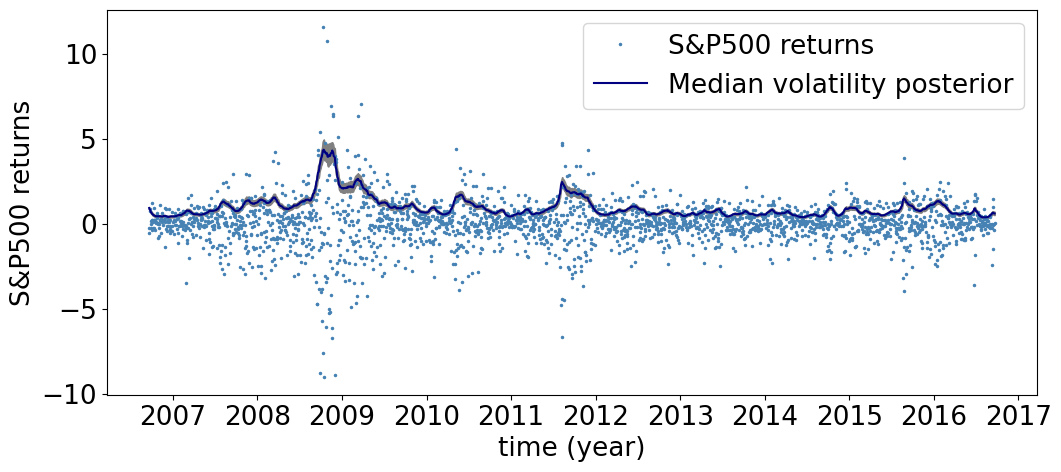

In [ ]:
# figure setup
plt.figure(figsize = (12, 5))

plt.plot(SP500_dates_mpl, SP500_returns, '.', markersize = 3, color= 'steelblue', label='S&P500 returns')
plt.plot(SP500_dates_mpl, median, color='navy', label='Median volatility posterior')
plt.fill_between(SP500_dates_mpl, lower_quartile, upper_quartile, color='gray')

plt.legend()
plt.xlabel('time (year)')
plt.ylabel('S&P500 returns')
plt.show()